# Learning Summary Statistics from Images

In this example, we will demonstrate how to use a Convolutional Neural Network to learn summary statistics from a 2D image, which then can be used for the sbi workflow seen previously.

The simulator in this example has been provided by Niklas Schwan, a PhD student at Helmholtz-Centre for Infection Research. In his working group, they are interested in investigating agent based models, where they allow normal cells to interact with tumor cells and study the outcomes for different initialization of the simulation. This is a perfectly suitable case for Simulation Based Inference.

## Two Cell Interaction simulation

For this, we will simulate the interaction between normal cells and tumor cells as a function of time in a simplistic scenario determined by initial conditions.

The possible variables that we will modify in this simulator are the speed of the normal and tumor cells, $v_N$ and $v_T$ respectively, and their cycle duration $w_N$ and $w_T$.

We will set as initial conditions:
- the grid,
- initial position of normal and tumor cells,
- radius iof the reaction volume,
- fraction of the phase width
- simulation duration,
- time step,
- persistency of movement of both type of cells.

The simulator is written in a C++ code. We will compile the executable binary for our current computer, and then run the executable using the `sys` python library. This is to show you one possibility of using an external simulator that is not written in Python. It would also be possible to wrap it with `PyBind`. 

We have provided the simulator in the `simulate_cell_growth.py` script. It is not necessary to look at it (go ahead if you want), but it is necessary to understand its inputs and outputs. The simulator has two input variables, one of them is the input parameter list (as a tensor or array), which would be 

```python
pvec = torch.tensor([w_T, v_T, w_N, v_N])
```

and the simulation output type, which can be one of `"observables"`, `image`, `both`. 

- If `image` is chosen, then the output will be directly the image of the configuration after 100 hours of interaction. This will be useful for the embedding network that we want to use. For a single simulation this image is of dimension $(65,65,3)$.

- If `observables` is chosen, then the output of the simulation will be the mean positions of the normal and tumor cell clusters, the 75% confining radius for both type of cells, and the total number of normal and tumor cells. These are be summary statistics that are calculated from the image of the final configurration after 100 seconds of interaction between cell types, which are understood by experts in the field to be useful for describing the configuration given the input parameters. 

- If `both`, then the output is a list, where the first element of the list is the image and the second element is the observables.   


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from simulators.cell_growth import simulator, FlexibleBoxUniform
from sbi.utils.user_input_checks import process_prior, process_simulator
from sbi.utils.simulation_utils import simulate_for_sbi
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding
from sbi.inference import NPE
from sbi.analysis.plot import pairplot

%matplotlib inline


We can see information about the simulator as follows:

In [2]:
help(simulator)

Help on function simulator in module simulate_cell_growth:

simulator(pvec, sim_type='observables')
    The simulator TwoCell has 16 inputs.
    pvec can be any combination of the parameters listed.
    pvec : torch.tensor, np.array, list
    sim_type: one of ["observables", "image", "both"]



Let's test the simulator to understand the output of a single simulation for the different simulation types.  You may see the code for the simulator in `simualte_cell_growth.py`, but there are other parameters that are kept fixed and initializes as follows:

```python
params["general"]["random_seed"] = -1
params["general"]["grid_constant"] = 5
params["general"]["radius_volume"] = 160
params["general"]["simulation_duration"] = 100
params["general"]["time_step"] = 0.002
params["general"]["width_phases"] = 0.5

params["tumor"]["initial_number"] = 1
params["tumor"]["cycle_duration"] = pvec[0]
params["tumor"]["mean_velocity"] = pvec[1]
params["tumor"]["persistence_polarity"] = 1.5
params["tumor"]["initial_position"] = 137312

params["normal"]["initial_number"] = 5
params["normal"]["cycle_duration"] = pvec[2]
params["normal"]["mean_velocity"] = pvec[3]
params["normal"]["persistence_polarity"] = 1.5
params["normal"]["initial_position"] = 133087
```

We've chosen these values to keep the simulation simple, but of course it is possible to estimate more parameters than the 4 that we've chosen.

### Image
Let's run the simulator with the output set as the image of the final configuration of the system after 1 hour of interaction.

In [3]:
%%time 
# avoid cell cycles lower than 7 hours because simulations become very slow since they reproduce too much and more calculations need to be performed to reach 100hs of simulation.
pvec = torch.tensor([8, 0.02, 10, 0.06])
data = simulator(pvec, sim_type="image")
data.shape

CPU times: user 2.86 ms, sys: 7.96 ms, total: 10.8 ms
Wall time: 5.27 s


torch.Size([65, 65, 3])

We can plot this image using `matplotlib` to see how it looks like

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


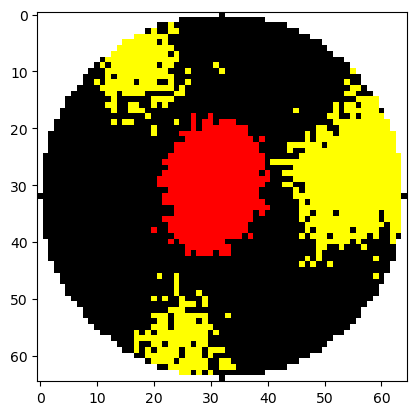

In [4]:
plt.figure()
plt.imshow(data)
plt.show()

In this image, red pixels represent tumor cells and yellow normal cells. You can play around with the inputs of `pvec` to see the outcomes of the simulation.

The actual simulation is a 3D simulation, but the representation that we are seeing is the projection on a 2D plane (XY), where the pixel is colores according to the dominant type of cell in it. If there are no cells, then the color is black. We can eventually work with the 3D configuration by simply adding one extra dimension to our tensor, but for simplicity, let's  keep the visualization and the problem in 2D. 

### Observables

Let's run a simulation with `sim_type="observables"`, where we set the cell cycle and the speed of normal cells to $\omega_N=14\,hs$ and $v_N=0.02\,\frac{\mu m}{min}$ respectively, and those of tumor cells to $\omega_N=24\,hs$ and $v_N=0.03\,\frac{\mu m}{min}$ 

In [5]:
pvec = torch.tensor([14, 0.02, 24, 0.03])
data = simulator(pvec, sim_type="observables")
data.shape

torch.Size([14])

In [6]:
pvec = torch.tensor([14, 0.02, 24, 0.03])
data = simulator(pvec, sim_type="observables")
data.shape

torch.Size([14])

the output is a tensor of size 14, where the mean position of the normal an tumor cells in `x,y,z` directions are given (indexes 0 to 5), then the 75% confining radius in each direction for each type of cell follow (indexes 6 to 11), and finally the total number of normal and tumor cells (indexes 12 and 13)

In [7]:
def print_summary(data):
    mean_pos_N = data[0:3].numpy()
    mean_pos_T = data[3:6].numpy()
    conf_radius_N = data[6:9].numpy()
    conf_radius_T = data[9:12].numpy()
    num_normal_cells = data[12].numpy()
    num_tumor_cells = data[13].numpy()
    
    print(f"{mean_pos_N=}\n{mean_pos_T=}\n{conf_radius_N=}\n{conf_radius_T=}\n{num_normal_cells=}\n{num_tumor_cells=}")

print_summary(data)

mean_pos_N=array([15., 16., 14.])
mean_pos_T=array([16., 20.,  0.])
conf_radius_N=array([24.8395, 24.2074, 24.7588])
conf_radius_T=array([37.3363, 40.8167, 50.2096])
num_normal_cells=array(151.)
num_tumor_cells=array(73.)


### both

There is also the possibility of asking for both outputs at the same time, but we won't be exploring this in this tutorial.

## SBI workflow

One possibility would be to use the summary statistics that the simulation provides by means of the `observables` keyword, as we have done previously and train a Masked Autoregressive Flow to estimate the posterior by means of the methos we've seen previously. But what if the summary statistics that we are using are note sufficient for the problem we want to solve? What if we could build up other statistics that might be better for our problem? What if we can let neural networks search and learn it's own summary statistics? This tutorial focuses on this last approach. We can in principle train a Neural Network, like a Convolutional Neural Network (CNN) to generate an embedding space where the information of the image is summarized, and we can use this embedding space variables as our "summary statistics" to feed in the sbi workflow. 

In order to see this difference, we will first infer the posterior distribution of our 4 variables from the summary statistics provided and then we will train the embedding CNN network to learn the summary statistics from the image output, to finally infer the posterior distribution. We will compare the advantages and disadvantages of both approaches.

### Generating the training data from the observables simulation

First we simulate the dataset on which we will train. We provide a pickle file with the already simulated data, but we also leave here the code in case you would want to run the simulator yourself. 

We will define a function that initializes our sbi workflow:

In [8]:
def initialize_sbi(low, high,sim_type):
    # example for:
    prior = FlexibleBoxUniform(
        low=low, high=high
    )
    print("Initializing BoxUniform prior o cpu.")
    prior.to("cpu")

    prior, theta_numel, prior_returns_numpy = process_prior(prior)
    print(f"{theta_numel} parameters to be estimated.")
    simul = process_simulator(
        lambda theta: simulator(theta, sim_type),
        prior,
        prior_returns_numpy,
    )
    return prior, simul

In [9]:
# theta -> (cycle_duration_tumor, mean_velocity_tumor, cycle_duration_normal, mean_velocity_normal)
low=torch.tensor([7, 0.12, 12, 0.12])
high=torch.tensor([20, 0.83, 30, 0.83])
prior, simul = initialize_sbi(low, high,sim_type="observables")

Initializing BoxUniform prior o cpu.
4 parameters to be estimated.


In [10]:
%%time 
num_simulations=5000
theta, x = simulate_for_sbi(simul, prior, num_simulations=num_simulations, num_workers=40)

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 20.2 s, sys: 2.86 s, total: 23.1 s
Wall time: 2min 54s


Great! Now we have the sample of size `num_simulations` from our prior $\theta$, and the corresponding simulation results in the tensor $x$.

We can see some of our priors samples and their simulations, as well as the shapes of these objects, so that we are sure of what we are doing.

In [11]:
theta.shape, x.shape

(torch.Size([5000, 4]), torch.Size([5000, 14]))

In [12]:
theta[:3], x[:3]

(tensor([[12.3681,  0.1488, 17.2536,  0.1531],
         [ 9.8531,  0.3205, 20.6918,  0.6953],
         [18.1606,  0.1234, 23.3038,  0.3799]]),
 tensor([[  17.0000,   13.0000,   16.0000,   17.0000,   21.0000,    0.0000,
            26.8701,   32.8024,   31.2410,   34.4819,   43.0465,   48.0208,
           263.0000,  196.0000],
         [  15.0000,   13.0000,   15.0000,   18.0000,   21.0000,    0.0000,
            29.7321,   32.0156,   31.6228,   36.7967,   51.4782,   47.2652,
          1028.0000,   97.0000],
         [  14.0000,   15.0000,   16.0000,   16.0000,   19.0000,    0.0000,
            25.5539,   30.0000,   33.4215,   41.0488,   42.7200,   47.7074,
            40.0000,   70.0000]]))

We can now proceed to train a MAF using $x$ as input to predict $\theta$. The NN architecture that we decide to use will depend on the problem we want to solve, as well as the amount of data that we have. You can play around with NN architectures, as well as with the sbi methodology chosen. In this example, we will use a MAF with 60 hidden features and 3 transforms to learn the posterior, and we will use `NPE`. We will train the NN on one GPU.

In [13]:
neural_posterior = posterior_nn(model="maf", hidden_features=60, num_transforms=3)

In [14]:
inferer = NPE(prior.to("cuda:0"), density_estimator=neural_posterior, device="gpu")

In [15]:
inferer = inferer.append_simulations(theta.to("cuda:0"), x.to("cuda:0"))
density_estimator = inferer.train()
posterior = inferer.build_posterior(density_estimator)

 Neural network successfully converged after 176 epochs.

We have trained a Masked Autoregressive Flow as the posterior estimator, that is a NN that estimates the $P(\theta|x)$.

Now, let's suppose we have a real observation `x_o` of the summary statistics. We will generate it with the simulator, but let's suppose we are observing a real image and calculating the mean position of the clusters, the 75% confining radius, and the number of cells of each type.

In [16]:
prior.to("cpu")
theta_o = prior.sample((1,))
print(theta_o)
x_o = simul(theta_o)
print_summary(x_o[0])

tensor([[19.3093,  0.5876, 29.9579,  0.3825]])
mean_pos_N=array([12., 14., 17.], dtype=float32)
mean_pos_T=array([16., 20.,  0.], dtype=float32)
conf_radius_N=array([24.5967, 38.3275, 34.7851], dtype=float32)
conf_radius_T=array([37.855 , 41.5933, 46.4004], dtype=float32)
num_normal_cells=array(34., dtype=float32)
num_tumor_cells=array(38., dtype=float32)


Since `NPE` grants us with an amoritzed posterior, we can now sample around the observed point, to get the conditional posterior estimation $P(\theta|x=x_o)$,

In [17]:
x_o

tensor([[12.0000, 14.0000, 17.0000, 16.0000, 20.0000,  0.0000, 24.5967, 38.3275,
         34.7851, 37.8550, 41.5933, 46.4004, 34.0000, 38.0000]])

In [18]:
num_samples = 10000
npe_posterior_samples = posterior.sample((num_samples,), x=x_o.to("cuda:0"))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

We can use the `pairplot` utility provided by the `sbi` package to plot the density estimations for our parameters, as well as the "observed value" (in orange). We always prefer narrower distributions centered around the observed value, meaning that the NN could infer the conditional probability correctly.

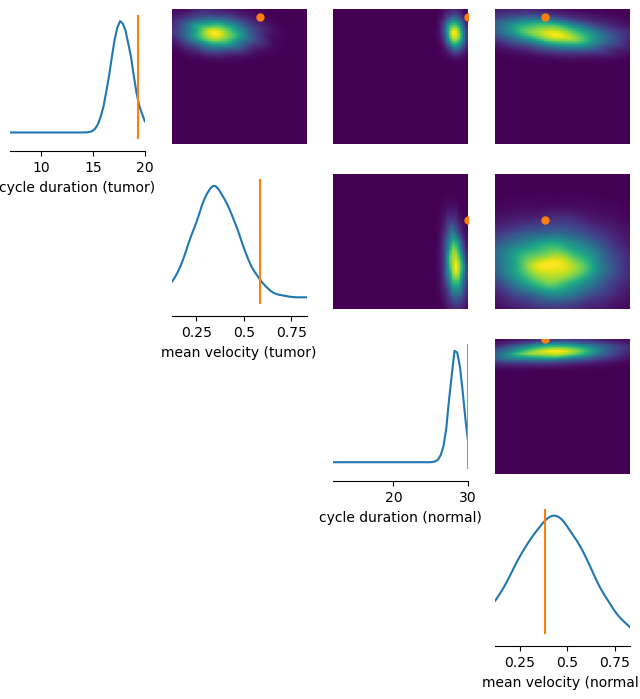

In [19]:
limits = torch.stack([low,high]).T
pairplot(
        npe_posterior_samples.cpu(),
        limits=limits,
        labels=[
            "cycle duration (tumor)",
            "mean velocity (tumor)",
            "cycle duration (normal)",
            "mean velocity (normal)",
        ],
        points=theta_o.cpu(),
        upper="kde",
        diag="kde",
        figsize=(8, 8),
    )
plt.show()

## Comparison with Image output

### Generating the dataset for training the posterior estimator

First we need to run new simulations in which the output is the 3-channel image as seen at the beginning of this notebook. 

In [20]:
prior, simul = initialize_sbi(low, high,sim_type="image")

Initializing BoxUniform prior o cpu.
4 parameters to be estimated.


In [21]:
%%time 
num_simulations=10000
theta, x = simulate_for_sbi(simul, prior, num_simulations=num_simulations, num_workers=40)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 47.7 s, sys: 3.82 s, total: 51.6 s
Wall time: 5min 4s


Now, we can see that our data structure has changed, and we have an image as $x$:

In [22]:
theta.shape, x.shape

(torch.Size([10000, 4]), torch.Size([10000, 65, 65, 3]))

Let's see some random simulations using $\theta$ sampled from our non-informative prior

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


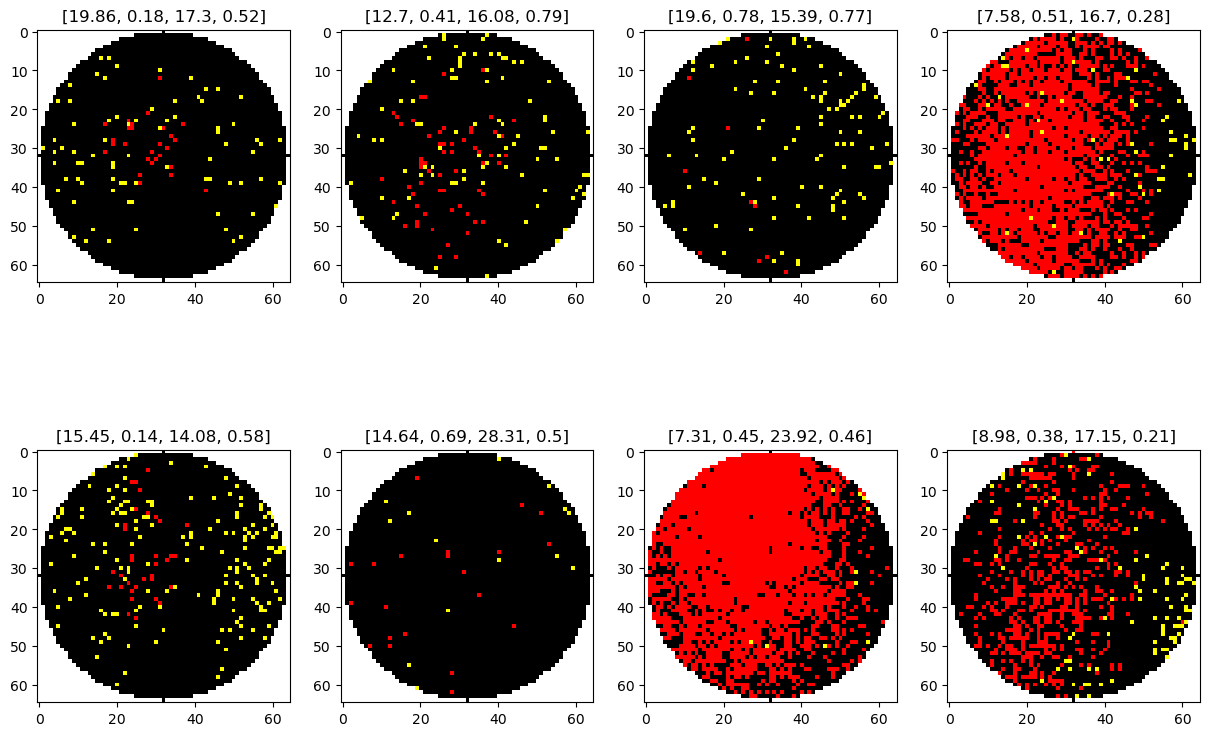

In [23]:
plt.figure(figsize=(15,10))
for i in range(0,8):
    title = [round(xi,2) for xi in theta[i].tolist()]
    plt.subplot(2,4,i+1)
    plt.title(title)
    plt.imshow(x[i])
plt.show()

### Training the posterior NN

Now we need to define the CNN that generates the embedding and train the posterior estimator. We will define the simples CNN embedding, but it is possible to customize this architecture completely.

In [24]:
embedding_net = embedding_net = CNNEmbedding(input_shape=(65, 65),
                                             out_channels_per_layer = [3,3],
                                             num_conv_layers=2,
                                             kernel_size=3,
                                             in_channels=3,
                                             num_linear_layers = 1,
                                             num_linear_units = 28,
                                             pool_kernel_size=4,
                                             output_dim=14)
neural_posterior_with_CNN = posterior_nn(model="maf", embedding_net=embedding_net)

In [25]:
prior.to("cuda:0")
inferer = NPE(prior, density_estimator=neural_posterior_with_CNN, device="cuda:0")
density_estimator = inferer.append_simulations(theta.to("cuda:0"), x.to("cuda:0")).train(training_batch_size=512)
posterior = inferer.build_posterior(density_estimator)

 Neural network successfully converged after 206 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

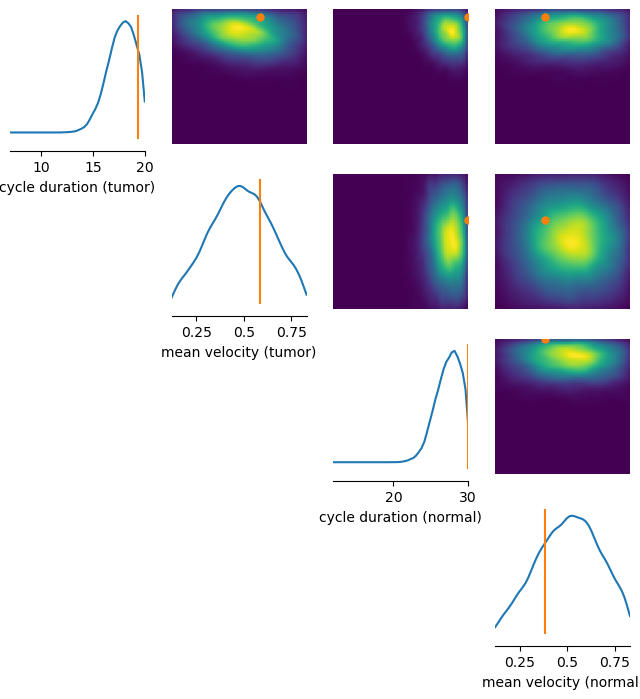

In [26]:
# Generate samples
x_o = simul(theta_o)

num_samples = 10000
npe_posterior_samples = posterior.set_default_x(x_o).sample((num_samples,))

limits = torch.stack([low,high]).T
pairplot(
        npe_posterior_samples.cpu(),
        limits=limits,
        labels=[
            "cycle duration (tumor)",
            "mean velocity (tumor)",
            "cycle duration (normal)",
            "mean velocity (normal)",
        ],
        points=theta_o.cpu(),
        upper="kde",
        diag="kde",
        figsize=(8, 8),
    )
plt.show()